In [1]:
import tensorflow as tf

from tensorflow.keras import Sequential, models, layers # type: ignore
from tensorflow.keras.applications import ResNet50 # type: ignore
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout # type: ignore
from tensorflow.keras.models import Model # type: ignore
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
data = np.load('C:/Users/PC_I/OneDrive/Desktop/EDC/npy DB/datasetWithoutCLAHE.npz')

train_images = data['train_images']
train_labels = data['train_labels']
val_images = data['val_images']
val_labels = data['val_labels']
test_images = data['test_images']
test_labels = data['test_labels']

print("Data loaded successfully!")


Data loaded successfully!


In [3]:
 # Function to resize images to 224x224
def resize_image(image):
    image = tf.image.resize(image, [224, 224]) # default input size for ResNet50
    return image

# Function to normalize the image
def normalize_images(image):
    # Assuming the images are already resized, only normalize them
    # Cast the image to float32 before normalization
    image = tf.cast(image, tf.float32)
    image = image / 255.0  # Normalize to [0, 1] range
    return image

# Function to augment the image
def augment_image(image):
    # Randomly flip the image horizontally and vertically
    # Flip with a 50% probability horizontally
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)

    # Flip with a 50% probability vertically
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_up_down(image)
    
    # Randomly rotate the image
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    
    # Randomly adjust brightness
    image = tf.image.random_brightness(image, max_delta=0.1)
    # Randomly adjust contrast
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    
    # Randomly zoom in
    image = tf.image.resize_with_crop_or_pad(image, 266, 266)  # Zoom in slightly
    image = tf.image.random_crop(image, size=[256, 256, 3])
    
    # Clip the image to ensure values are in the range [0, 1]
    image = tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)
    
    return image

# Combined function that loads and preprocesses the image
def load_and_preprocess_image(image, label, data_augmentation=True):
 
    # Normalize and resize the image
    image = normalize_images(image)
 
    # Apply data augmentation if specified
    if data_augmentation:
        image = augment_image(image)
        #print(f"After data augmentation: {image.shape,image.dtype}") 
        
    # resize the image
    image = resize_image(image)
    
    return image, label


In [4]:
# create TensorFlow datasets for each split
# When loading datasets, pass the data_augmentation flag True or False to apply or skip augmentations:
train_dataset = tf.data.Dataset.from_tensor_slices( (train_images , train_labels) )
train_dataset = train_dataset.map(lambda x, y: load_and_preprocess_image(x, y, data_augmentation=True), num_parallel_calls=tf.data.AUTOTUNE)
# the augmentations will be applied automatically every time you fetch an image from the train_dataset while data_augmentation=True
# During the training process, each time the model accesses train_dataset, it retrieves the images along with their augmentations.

val_dataset = tf.data.Dataset.from_tensor_slices( (val_images , val_labels) )
val_dataset = val_dataset.map(lambda x, y: load_and_preprocess_image(x, y, data_augmentation=False), num_parallel_calls=tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices( (test_images , test_labels) )
test_dataset = test_dataset.map(lambda x, y: load_and_preprocess_image(x, y, data_augmentation=False), num_parallel_calls=tf.data.AUTOTUNE)

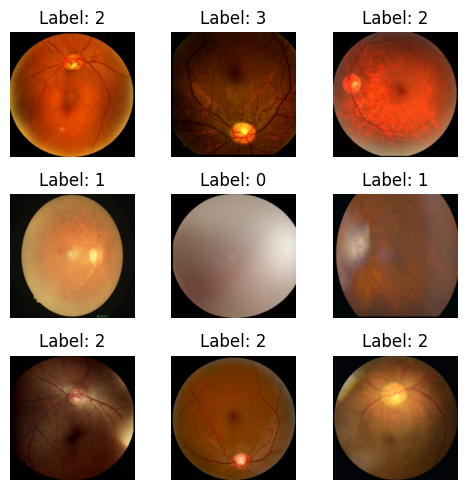

In [32]:
def display_sample_grid(dataset, num_samples=9, grid_size=(3, 3)):
    # Set up the grid
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(5, 5))
    
    # Flatten the axes for easy iteration
    axes = axes.flatten()
    
    # Take the specified number of samples from the dataset
    for idx, (image, label) in enumerate(dataset.take(num_samples)):
        # Plot each image in the corresponding grid cell
        image = cv2.cvtColor(image.numpy(), cv2.COLOR_RGB2BGR)
        axes[idx].imshow(image)
        
        # Set title to display the label only (no image name available)
        axes[idx].set_title(f'Label: {label.numpy()}')
        axes[idx].axis('off')  # Hide the axes for a cleaner look
    
    plt.tight_layout()  # Adjusts the spacing between subplots
    plt.show()

# Test with training dataset, displaying 9 images in a 3x3 grid
display_sample_grid(train_dataset, num_samples=9, grid_size=(3, 3))


In [5]:
#prepare your datasets for model training and evaluation

batch_size=32  # Specify your desired batch size here
  
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(buffer_size= tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=batch_size*100)  # Shuffle with buffer size

val_dataset = val_dataset.batch(batch_size)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
 

test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [47]:
# Assuming you have a TensorFlow dataset

# For example: train_dataset, val_dataset, test_dataset
for image, label in train_dataset.take(1):
    print("Data type of images:", image.dtype)
    print("Data type of labels:", label.dtype)
    print("Image batch shape:", image.shape)
    print("Label batch shape:", label.shape)

Data type of images: <dtype: 'float32'>
Data type of labels: <dtype: 'int32'>
Image batch shape: (32, 224, 224, 3)
Label batch shape: (32,)


During the training loop:

The augmentations will be executed on-the-fly for each epoch. 
In every epoch, when the model requests a batch of images from the train_dataset, your augmentation function applies random transformations (like flipping, rotating, zooming).
Since the augmentations are random, the same image will appear differently in different epochs, effectively increasing the diversity of the training data and improving the model's generalization ability.

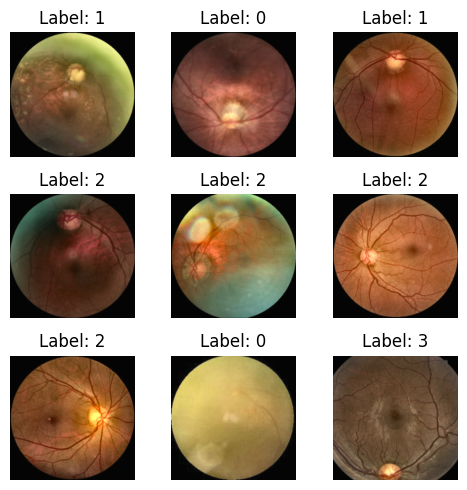

In [63]:

def display_sample_grid(dataset, num_samples=9, grid_size=(3, 3)):
    # Set up the grid
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(5, 5))
    
    # Flatten the axes for easy iteration
    axes = axes.flatten()
    
    # Take the specified number of samples from the dataset
    count = 0
    for batch_images, batch_labels in dataset:
        for image, label in zip(batch_images, batch_labels):
            if count >= num_samples:
                break
            
            # Convert image from tensor to numpy and from RGB to BGR (for OpenCV compatibility)
            image = image.numpy()  # Convert tensor to numpy
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)  # Convert RGB to BGR for OpenCV
            
            # Plot each image in the corresponding grid cell
            axes[count].imshow(image)
            axes[count].set_title(f'Label: {label.numpy()}')
            axes[count].axis('off')  # Hide the axes for a cleaner look
            
            count += 1
        if count >= num_samples:
            break
    
    plt.tight_layout()  # Adjusts the spacing between subplots
    plt.show()

# Test with training dataset, displaying 9 images in a 3x3 grid
display_sample_grid(train_dataset, num_samples=9, grid_size=(3, 3))


In [6]:
# Load ResNet50 with pre-trained weights, exclude the top layers
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
# Freeze the base model to prevent retraining
base_model.trainable = False

In [54]:
# # Add custom layers on top of the pre-trained model
# model = base_model.output
# model = GlobalAveragePooling2D()(model)  # Add global average pooling
# model = Dense(128, activation='relu')(model)  # Add a fully connected layer
# model = Dropout(0.2)(model)  # Dropout with a rate of 20%
# predictions = Dense(4, activation='softmax')(model)  # Output layer (for 4 classes)
# 
# # Create the final model
# model = Model(inputs=base_model.input, outputs=predictions)

In [7]:
model = models.Sequential()

model.add(base_model)
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(4, activation='softmax'))

In [8]:
# Define the callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',  # Monitoring validation accuracy
    patience=10,  # Number of epochs with no improvement after which training will be stopped
    verbose=1,
    mode='max',  # Stops training when the quantity monitored has stopped increasing
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity)
)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='C:/Users/PC_I/OneDrive/Desktop/EDC/model_epoch_{epoch:02d}.weights.h5',  # Save file with epoch number
    monitor='val_accuracy',
    verbose=1,
    save_weights_only=True,
    save_best_only=False
)

# Add callbacks to the fit method
callbacks = [early_stopping, model_checkpoint]


In [10]:
# Assuming you have defined your model architecture as `model`
try:
    model.load_weights('C:/Users/PC_I/OneDrive/Desktop/EDC/model_epoch_09.weights.h5')
except ValueError as e:
    print(f"Error loading weights: {e}")


In [11]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.00001)  # Try a lower value like 0.00001 or higher like 0.001

model.compile(optimizer=optimizer, 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])


In [ ]:
# Continue training for the remaining epochs
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    #initial_epoch=87,  # Set this to the epoch number you finished on
    epochs=10,  # Continue for the total desired epochs
    callbacks=[model_checkpoint, early_stopping]
)



Epoch 1/10
 8/80 ━━━━━━━━━━━━━━━━━━━━ 2:51 2s/step - accuracy: 0.2455 - loss: 2.0439

In [12]:
model.save('C:/Users/PC_I/OneDrive/Desktop/best_model_epoch_57.keras')

In [12]:
# Evaluate on training data
train_loss, train_accuracy = model.evaluate(train_dataset, verbose=0)
print(f"Training Accuracy: {train_accuracy}")

# Evaluate on validation data
val_loss, val_accuracy = model.evaluate(val_dataset, verbose=0)
print(f"Validation Accuracy: {val_accuracy}")


Training Accuracy: 0.5931198000907898
Validation Accuracy: 0.571090042591095


In [13]:
# Evaluate on test data
test_loss , test_accuracy = model.evaluate(test_dataset, verbose=0)
print(f"Test Accuracy: {test_accuracy}")

Test Accuracy: 0.6054502129554749


In [14]:
# Plot training & validation accuracy values
plt.figure(figsize=(13,5))
plt.plot(history.history['accuracy'],color="#E74C3C", marker='o')
plt.plot(history.history['val_accuracy'], color='#641E16', marker='h')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(13,5))
plt.plot(history.history['loss'],color="#E74C3C", marker='o')
plt.plot(history.history['val_loss'], color='#641E16', marker='h')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend( ['Train', 'Validation'], loc='upper left')
plt.show()

NameError: name 'history' is not defined

<Figure size 1300x500 with 0 Axes>

In [75]:
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Step 1: Load your saved model (e.g., model from the last epoch)
try:
    model.load_weights('C:/Users/PC_I/OneDrive/Desktop/EDC/model_epoch_78.weights.h5')
except ValueError as e:
    print(f"Error loading weights: {e}")

# Step 2: Make predictions on the validation dataset
y_true = []
y_pred = []

# Iterate through the validation dataset and collect predictions and true labels
for images, labels in val_dataset:  # Assuming val_dataset is already batched
    predictions = model.predict(images)
    
    # Append the true labels directly if they are integer-encoded
    y_true.extend(labels.numpy())  # Convert TensorFlow tensor to numpy array

    # Append the predicted labels (taking the argmax of the predictions)
    y_pred.extend(np.argmax(predictions, axis=1))  # Predicted labels

# Step 3: Define class names
class_names = ['Cataract', 'Glaucoma', 'Normal', 'DR']  # Adjust based on your classes

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Print the class names above the confusion matrix
print(f"Class Names: {', '.join(class_names)}\n")

# Print confusion matrix with class labels
print("Confusion Matrix:\n", conf_matrix)

# Classification report (includes precision, recall, f1-score for each class)
report = classification_report(y_true, y_pred, target_names=class_names)

# Print the class names above the classification report
print(f"\nClassification Report for Classes: {', '.join(class_names)}")
print("\n", report)

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 940ms/step
Class Names: Cataract, Glaucoma, Normal, DR

Confusion Matrix:
 [[165  38   3   2]
 [ 70  94  23  14]
 [ 58  43  78  36]
 [ 15  34  43 128]]

Classification Report for Classes: Cataract, Glaucoma, Normal, DR

               precision    recall  f1-score   support

    Cataract       0.54      0.79      0.64       208
    Glaucoma       0.45      0.47      0.46       201
      Normal       0.53      0.36      0.43       215
          DR       0.71      0.58      0.64       220

    accurac

In [76]:
# Step 4: Calculate per-class accuracy from the confusion matrix
per_class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
for idx, accuracy in enumerate(per_class_accuracy):
    print(f"Accuracy for class {class_names[idx]}: {accuracy:.2f}")


Accuracy for class Cataract: 0.79
Accuracy for class Glaucoma: 0.47
Accuracy for class Normal: 0.36
Accuracy for class DR: 0.58
